# Курсовой проект для курса "Python для Data Science"  

Материалы к проекту (файлы):

* train.csv
* test.csv

### Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

### Целевая переменная: Price

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Сдача проекта:

1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

### Сроки и условия сдачи:

* Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
* Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
* При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
* Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
* Успешный проект нельзя пересдать в целях повышения результата.
* Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
* В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

## Импорт библиотек. Настройка графиков.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use(['dark_background']) # тёмный фон графиков ['dark_background']

## Загрузка датасета

In [6]:
train_dataset = '../Ds_libs/data/train.csv'
test_dataset = '../Ds_libs/data/test.csv'
df_orig = pd.read_csv(train_dataset)
df_test_orig = pd.read_csv(test_dataset)
print(df_orig.shape)

(10000, 20)


In [7]:
# Заголовок датасета
df_orig.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
# Описание датасета
df_orig.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
# Проверка наличия пропущенных значений
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

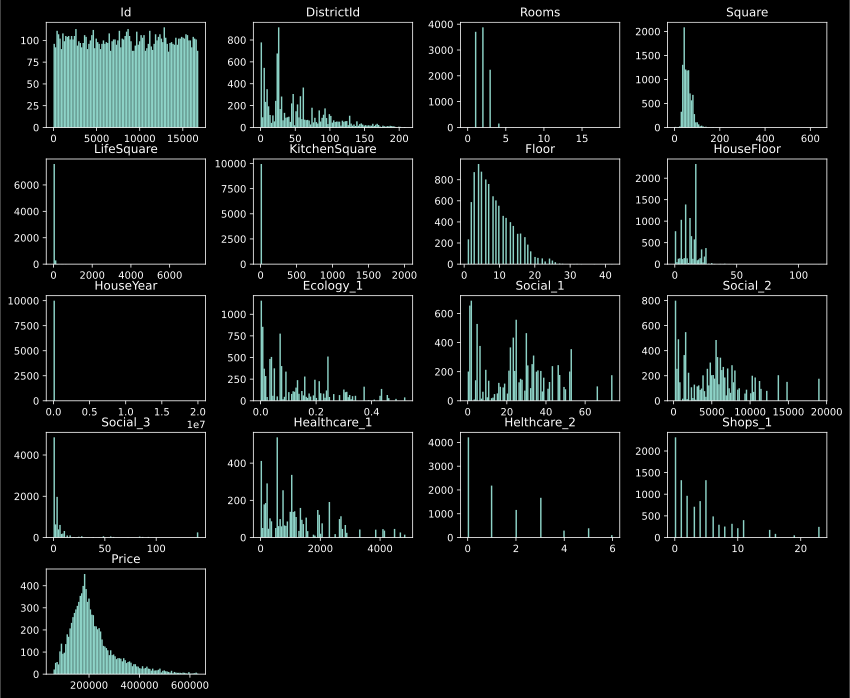

In [10]:
# Просмотр распределения признаков датасета
df_orig.hist(figsize=(14,12), bins=100, grid=False);

## Обработка данных:
* замена пропущенных значений Healthcare_1 на медианные;
* пустые LifeSquare = Square /1.62;
* если жилая площадь больше общей площади, то - общая площадь = жилой;
* замена LifeSquare < 10 на Square / 1.62;
* если Room == 0, то Room = 1; 
* удалил => если HouseFloor == 0, то HouseFloor = Floor * 2
* если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома;
* удалить Id, LifeSquare
* drop (['Price', 'Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B'])

In [11]:
df = df_orig
df_test = df_test_orig

# Замена некорректных значений года постройки 4968 и 20052010 в строчке № 4189 и 1497 столбца HouseYear
df['HouseYear'].describe().round()
df['HouseYear'].sort_values(ascending=False).head()

# замена значения в строчке № 4189 столбца HouseYear на значение
df.loc[4189, 'HouseYear'] = 1968
df.loc[1497, 'HouseYear'] = 2005
df.loc[1497, 'HouseYear']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

#df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

# вычисление коэффициента отношения площадей
#df['sq_mult'] = df['Square'] / df['LifeSquare']
#df_test['sq_mult'] = df_test['Square'] / df_test['LifeSquare']

df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] / 1.62  # mean & 50% sq_mult
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] / 1.62

# Если жилая площадь больше общей площади, то общая площадь = жилой
df['Square'] = np.where((df['LifeSquare'] > df['Square']), df['LifeSquare'], df['Square'])
df_test['Square'] = np.where((df_test['LifeSquare'] > df_test['Square']), df_test['LifeSquare'], df_test['Square'])

# замена LifeSquare < 10 на Square / 1.62
df['LifeSquare'] = np.where((df['LifeSquare'] < 10), df['Square'] / 1.62, df['LifeSquare'])
df_test['LifeSquare'] = np.where((df_test['LifeSquare'] < 10), df_test['Square'] / 1.62, df_test['LifeSquare'])

# если Room = 0, то Room = 1
df['Rooms'] = np.where((df['Rooms'] == 0), 1, df['Rooms'])

# Замену HouseFloor = 0 на df['Floor'] * 2 в 269 кваритрах. Т.е. квартиры в среднем этаже
#df['HouseFloor'] = np.where((df['HouseFloor'] == 0), df['Floor'] * 2, df['HouseFloor'])

# если этаж квартиры выше этажности дома, то этаж квартиры равен этажности дома
df['Floor'] = np.where((df['Floor'] > df['HouseFloor']), df['HouseFloor'] , df['Floor'])

df = df.drop('Id', axis=1)
df = df.drop('LifeSquare', axis=1)
df_test = df_test.drop('Id', axis=1)
df_test = df_test.drop('LifeSquare', axis=1)

y = df['Price']
x = df.drop(['Price', 'Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B'], axis=1)
df_test = df_test.drop(['Helthcare_2', 'Shops_2_A', 'Shops_2_B', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B'], axis=1)

In [12]:
df.describe()
x

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1
0,35,2.0,47.981561,6.0,7.0,9.0,1969,0.089040,33,7976,5,900.0,11
1,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,46,10309,1,240.0,16
2,53,2.0,44.947953,0.0,8.0,12.0,1968,0.049637,34,7759,0,229.0,3
3,58,2.0,53.352981,9.0,8.0,17.0,1977,0.437885,23,5735,3,1084.0,5
4,99,1.0,39.649192,7.0,11.0,12.0,1976,0.012339,35,5776,1,2078.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,5.0,5.0,5.0,1968,0.135650,46,7960,6,350.0,11
9996,18,1.0,41.521546,9.0,13.0,13.0,2000,0.000000,30,5562,0,900.0,5
9997,27,1.0,47.939008,1.0,12.0,16.0,2015,0.072158,2,629,1,900.0,0
9998,75,2.0,43.602562,8.0,1.0,5.0,1961,0.307467,30,5048,9,325.0,5


## Построение моделей

### Random Forest Regressor

Обучение с разделением на тренировочную и валидационную выборку

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(df_test)

model = RandomForestRegressor(random_state=42, max_depth=25)
model.fit(x_train, y_train)

y_test = model.predict(x_test)
y_pred = model.predict(x_valid)
mae_valid = mae(y_valid, y_pred)
print(f'MAE valid: {mae_valid.round(0)}')

y_pred_train = model.predict(x_train)
mse_valid = mse(y_valid, y_pred)
print(f'MSE valid: {mse_valid.round(0)}')

r2_train = r2(y_train, y_pred_train)
print(f'R2 train: {r2_train.round(4)}')
r2_valid = r2(y_valid, y_pred)
print(f'R2 valid: {r2_valid.round(4)}')
model

MAE valid: 28871.0
MSE valid: 2477391095.0
R2 train: 0.9626
R2 valid: 0.7188


RandomForestRegressor(max_depth=25, random_state=42)

### Random Forest Regressor

Обучение на всей выборке без разделения на тренировочную и валидационную

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x)

x_test = scaler.transform(df_test)

model = RandomForestRegressor(random_state=42, max_depth=14)
model.fit(x_train, y)

y_test = model.predict(x_test)

y_pred_train = model.predict(x_train)

r2_train = r2(y, y_pred_train)
print(f'R2 train: {r2_train.round(4)}')
model

R2 train: 0.9199


RandomForestRegressor(max_depth=14, random_state=42)

#### Просмотр значимости признаков

In [15]:
model.feature_importances_
feature_importances = pd.DataFrame()
feature_importances['importance'] = model.feature_importances_
feature_importances['feature_name'] = x.columns.tolist()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,importance,feature_name
2,0.415255,Square
8,0.106647,Social_1
9,0.096089,Social_2
1,0.081681,Rooms
10,0.058447,Social_3
0,0.047003,DistrictId
7,0.042751,Ecology_1
6,0.036653,HouseYear
3,0.026223,KitchenSquare
11,0.024497,Healthcare_1


#### Построение графика значимости признаков

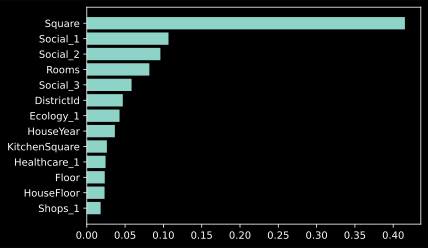

In [16]:
feature_importances = feature_importances.sort_values(by='importance', ascending=True)
height = feature_importances['importance']
bars = feature_importances['feature_name']
y_pos = np.arange(len(bars))
# Create horizontal bars
plt.barh(y_pos, height)
 # Create names on the y-axis
plt.yticks(y_pos, bars)
plt.show();

### Экспорт в CSV

In [17]:
#check_test = pd.DataFrame({'y_test_1': y_valid.round(), 'y_pred': y_pred.round()})
#check_test.head(10)
df_y_test = pd.DataFrame({'Id': df_test_orig['Id'], 'Price': y_test})
df_y_test.to_csv('../Ds_libs/data/IRostovskiy_predictions.csv', index=False, encoding='utf-8')
print('Done!')

Done!


In [22]:
# datetime object containing current date and time
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
file_name = f'../Ds_libs/data/IRostovskiy_predictions_{now}.csv'
print(file_name)
df_y_test.to_csv(file_name, index=False, encoding='utf-8')
print('File saved to disk!')

!kaggle competitions submit -c realestatepriceprediction \
  --file {file_name} -m { round(r2_train, 5)} -q

../Ds_libs/data/IRostovskiy_predictions_2021-12-06_21-58-32.csv
File saved to disk!
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.5.12', 'console_scripts', 'kaggle')())
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load_unlocked
  File

In [23]:
# запрашиваем сабмиты. ! - run it in a shell instead of interpreting it as python code
!kaggle competitions submissions  -c realestatepriceprediction

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.5.12', 'console_scripts', 'kaggle')())
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<fr

In [24]:
#   -s, --show           Show the top of the leaderboard
#  -d, --download        Download entire leaderboard
!kaggle competitions leaderboard realestatepriceprediction -s

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.5.12', 'console_scripts', 'kaggle')())
  File "/Library/Frameworks/Python.framework/Versions/3.8/bin/kaggle", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<fr